# 🐶 Multi-class Dog Breed Classification

This notebooks build a multi-class image classifier using TensorFlow 2.0 and TensorFlow hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog. Being able to upload a jpeg image of my dog (RIP Scoobie) and have the prediction output equal to Beagle.

## 2. Data
The data used is from Kaggle's dog breed identification competition.

> https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed for each test image.

> https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features


Dealing with images (unstructured data) it makes most sense to implement deep learning/transfer learning.

* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [0]:
#!unzip "/content/drive/My Drive/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Vision/"

__Get our workspace ready__
* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [0]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.2.0-rc2


In [0]:
import tensorflow_hub as hub 
print("TF Hub version:", hub.__version__)

# GPU availability
print("GPU", "available (YAY!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Hub version: 0.8.0
GPU available (YAY!!!)


Getting data ready (turning into Tensors) by converting into numerical format. Tranferring images into Tensors (numerical representations).

Start by accessing data and displaying labels.

In [0]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     836962e1a82fcb77511051bb7ca5152d  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


82.0

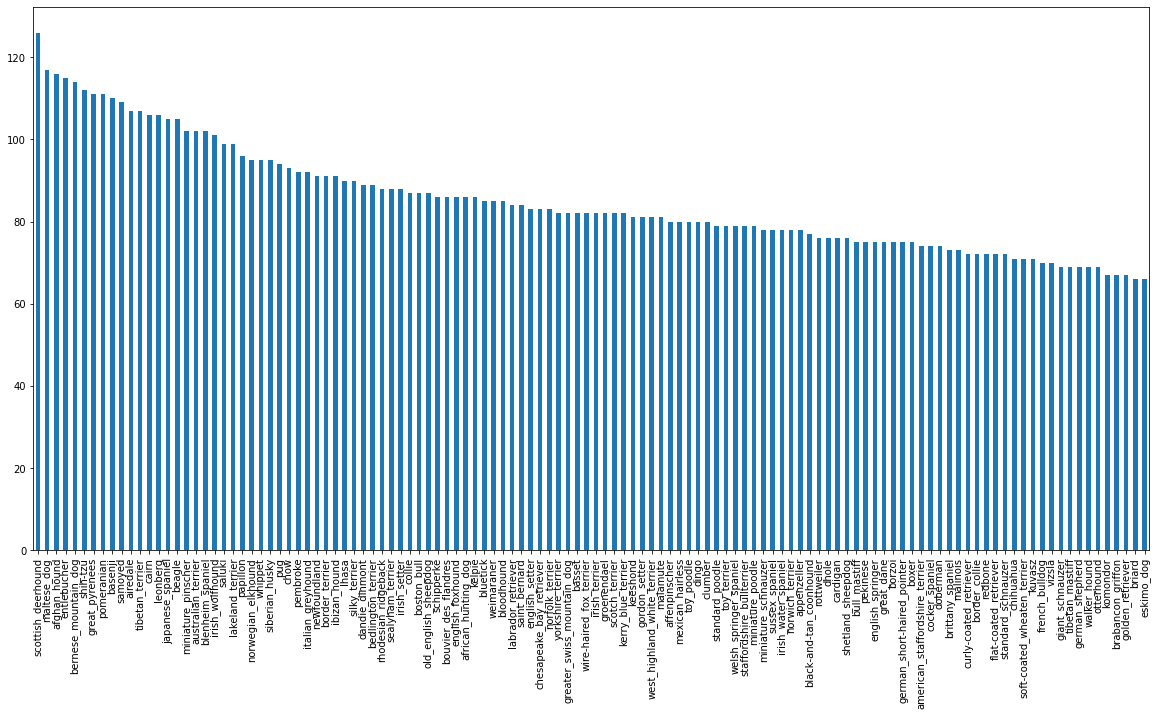

In [0]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))
# Average images per breed
labels_csv["breed"].value_counts().median()
# google recommends 100 images per label (at least 10 min per class)

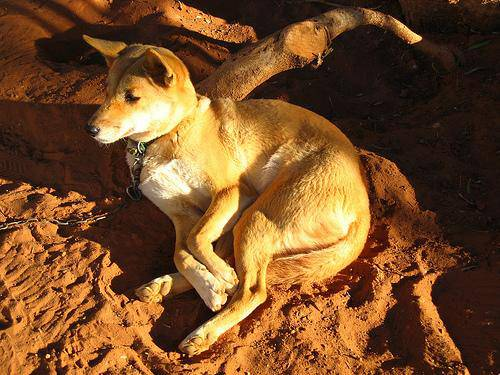

In [0]:
# Let's view an image
from IPython.display import Image
Image("/content/drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")


#### Images and lables
* Obtain list of all image file pathnames [bold text]

In [0]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [0]:
# Create pathnames from image ID's - take [id] value and save to list
filenames = ["/content/drive/My Drive/Dog Vision/train/"+ filename + ".jpg" for filename in labels_csv["id"]] 
# Check first 10
filenames[:10]

['/content/drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
import os
os.listdir("/content/drive/My Drive/Dog Vision/train/")[:10]

['f07d7513b336f4cf1ac5be3b46eecd66.jpg',
 'f6082c4fcbaec253ffe964f13aba012d.jpg',
 'f662df0beaf91c254157863bf00ac62e.jpg',
 'f692fcf95607b6e82528b0e90d705725.jpg',
 'f1a94cfd3e3c67736b961587e1795a1a.jpg',
 'f61d861726155de0ebd1a8e1e892f5af.jpg',
 'f111b639af2c7bd5e7e91e7595913894.jpg',
 'f20709a67b3a33528b56cfbb4ef3237b.jpg',
 'ea829d433019aedcdeb0215c10ea905b.jpg',
 'ea607b36bd3391a5b4fe4c547f5dd7c7.jpg']

In [0]:
# Checking number of filenames matches number of image files
import os
if len(os.listdir("/content/drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Amounts Match. Proceed.")
else:
  print("Filesnames do not match actual amount of files, check target directory")

Filenames match actual amount of files!!! Proceed.


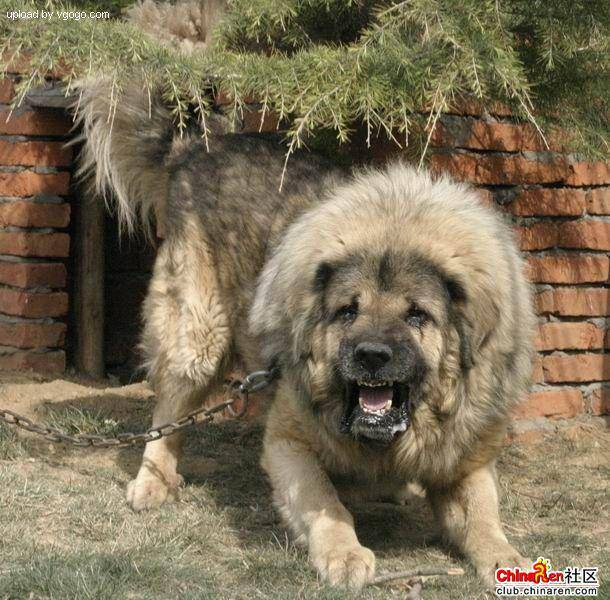

In [0]:
# One more check
Image(filenames[9000])

In [0]:
labels_csv["breed"][9000]

'tibetan_mastiff'

## Prepare Labels

In [0]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) #does same thing as above line
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [0]:
len(labels)

10222

In [0]:
# See if number of labels meatches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds  #120 unique breeds len(unique_breeds)

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [0]:
# Turn label into boolean array
print(labels[0])
labels[0] == unique_breeds  #boston_bull

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [0]:
# Transfer labels into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
len(boolean_labels)

10222

In [0]:
# Example: Turning boolean array into integers
print(labels[0]) 
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in a boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [0]:
print(labels[2])
print(boolean_labels[0].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# **Creating Custom Validation Set**


In [0]:
# Setup X & y variables 
X = filenames
y = boolean_labels

In [0]:
len(filenames)

10222

Experiment with ~1000 images and create toggle handle to increase if needed

In [0]:
# Set number of images
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step: 10}

In [0]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [0]:
# Check training data
X_train[:2], y_train[:2]

(['/content/drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fals

###Image Processing (Tensors)
Function to preprocess images into tensors:

1. Image filepath as input
2. Use TensorFlow read file and save it as variable `image`
3. Turn `image` (a jpg) into tensor
4. Normalize `image` (convert color channel values from from 0-255 to 0-1).
5. Resize `image` to be a shape of (224, 224)
6. Return modified `image`



In [0]:
# Convert image to NumPy array
from matplotlib.pyplot import imread #imageread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [0]:
image [:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [0]:
image.max(), image.min()

(255, 0)

In [0]:
# turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>



More information on loading images in TensorFlow can be seen here: 
> https://www.tensorflow.org/tutorials/load_data/images

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
# TUrn jpeg image into numerical Tensor with 3 colour channels (red, green, blue
  image = tf.image.decode_jpeg(image, channels=3)
  # COnvert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [0]:
# tensor = tf.io.read_file(filenames[26])
# tensor

In [0]:
# tf.image.decode_jpeg(tensor, channels=3)

In [0]:
# tf.image.convert_image_dtype(tensor, tf.float32)

Turning our data into batches to ease memory consumption. 

Convert data to the form Tensor tuples: (image, label).

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associate label, processes the image
  and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [0]:
# Demo of above
(process_image(X[42])), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

## Batches

Data is now converted to Tensor format: `(image, label)`. Proceed with function  to turn all data `(X & y)` into batches

In [0]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32   #CAPITALIZE is norm for TF hyperparameters
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test dtaa as input (no labels).
  """
  # If the data is a test dataset, we don't have labels.
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # only filepaths (no labels) - turns X into sensor
    data_batch = data.map(process_image).batch(BATCH_SIZE)  # pass me tensors and make dataset from it
    return data_batch

# IF the data is a valid dataset, no need to shuffle it.
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)  # pass me tensors and make dataset from it
    return data_batch

  else:
    print("Creating training data batches...")
      # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor funciton is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))  #shuffle all
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)  # more efficient to process on filepaths than the images themselves
    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch
  

In [0]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [0]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [0]:
y[0]  # 120 different dog breeds and same for validation data

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])


### Visualizing Data Batches¶


In [0]:
import matplotlib.pyplot as plt

#Create a function for viewing images in a data batch 
def show_25_images(images, labels):
  """
  displays a plot of 25 images and their labels from a data batch.
  """
  #Setup a figure
  plt.figure(figsize=(10,10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplot (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [0]:
unique_breeds[y[0].argmax()]

'boston_bull'

In [0]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[1.81012332e-01, 2.67286867e-01, 1.79734319e-01],
          [8.67003128e-02, 1.71653047e-01, 9.19436589e-02],
          [1.59136847e-01, 2.41174668e-01, 1.78514749e-01],
          ...,
          [4.92663942e-02, 8.91122967e-02, 5.64793125e-02],
          [1.28770798e-01, 1.48378640e-01, 1.32692367e-01],
          [8.07162970e-02, 1.00324146e-01, 8.46378654e-02]],
 
         [[1.08518645e-01, 1.90827832e-01, 1.24396794e-01],
          [1.26655594e-01, 2.08964780e-01, 1.49139121e-01],
          [1.84572905e-01, 2.63004273e-01, 2.16388360e-01],
          ...,
          [3.73127908e-02, 7.69906566e-02, 4.51524109e-02],
          [1.01470120e-01, 1.21077962e-01, 1.05391689e-01],
          [7.71792829e-02, 9.67871249e-02, 8.11008513e-02]],
 
         [[2.19924390e-01, 2.95668423e-01, 2.67270923e-01],
          [1.22034535e-01, 1.97778583e-01, 1.73452601e-01],
          [1.30756766e-01, 2.06500828e-01, 1.84643328e-01],
          ...,
          [8.60331208e-02, 1.10822976e-01, 9.3561

In [0]:
# length is 32 since our batch size is 32
len(train_images), len(train_labels)

(32, 32)

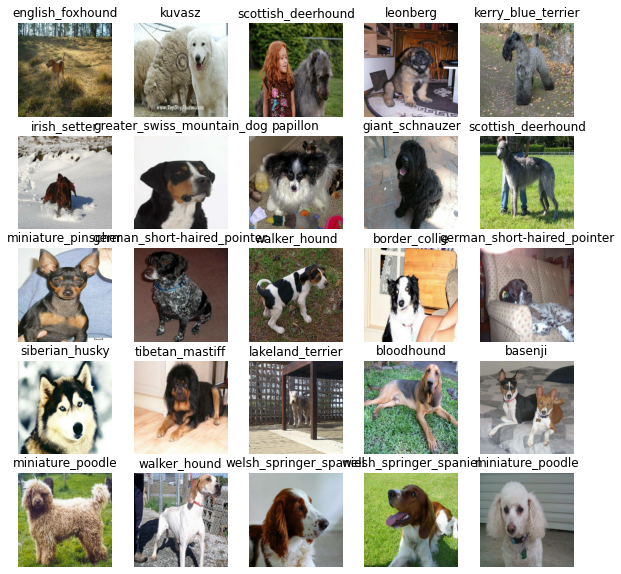

In [0]:
# Visualizing data in a training batch (our training data)
show_25_images(train_images, train_labels)

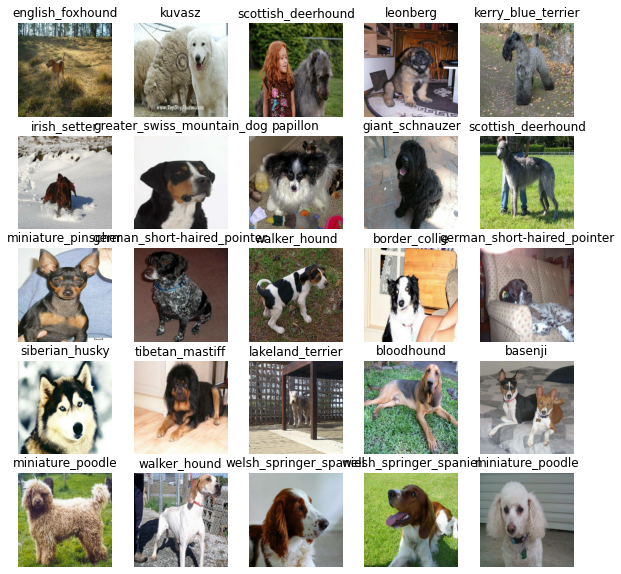

In [0]:
# Visualizing validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(train_images, train_labels)


Building a model:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TENSORFLOW HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

# Deep Learning Model

In [0]:
INPUT_SHAPE

[None, 224, 224, 3]


Create a function which:

* Defines the layers in a Keras model in **sequential** fashion.
* Compiles the model.
* Builds the model.
* Returns the model.
> Steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a function to build the keras mdel
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ]) 

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(), 
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [0]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_2 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________



Callbacks
> Callbacks are helper functions a model can use during training to do such things as save, check, or stop training if model ceases to improve. 


Setting up TensorBoard Callback:

* Load the TensorBoard notebook extension ✅
* Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit() `function. ✅
* Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard


In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  logdir = os.path.join("/content/drive/My Drive/Dog Vision/logs",
                        # Enable log tracking for experiments
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

Early Stopping Callback
Early stopping helps stop model from overfitting by stopping training if a certain evaluation metric ceases to improve over time.

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)


Training a model (on subset of data)

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [0]:
# Checking to make sure GPU is running 
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSS!!!!!!)



Function for model creation:

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session every time we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validaiton_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model


In [0]:
# Fit model to data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 2/25 [=>............................] - ETA: 6s - loss: 5.8799 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.255890). Check your callbacks.


25/25 [==============================] - 6s 232ms/step - loss: 4.5744 - accuracy: 0.1088 - val_loss: 3.4521 - val_accuracy: 0.2450
Epoch 2/100
25/25 [==============================] - 4s 172ms/step - loss: 1.6341 - accuracy: 0.6712 - val_loss: 2.1061 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 4s 175ms/step - loss: 0.5770 - accuracy: 0.9325 - val_loss: 1.6342 - val_accuracy: 0.6350
Epoch 4/100
25/25 [==============================] - 5s 180ms/step - loss: 0.2576 - accuracy: 0.9850 - val_loss: 1.4602 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 5s 192ms/step - loss: 0.1513 - accuracy: 0.9987 - val_loss: 1.3902 - val_accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 5s 187ms/step - loss: 0.1024 - accuracy: 1.0000 - val_loss: 1.3467 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================] - 4s 179ms/step - loss: 0.0770 - accuracy: 1.0000 - val_loss: 1.3157 - val_accuracy: 0.6450
Epoch 8/100



Note: Model learning with indications of overfitting. 


TensorBoard logs 
> TensorBoard magic function (`%tensorboard`) accesses logs and directory and visualizes contents.

In [0]:
%tensorboard --logdir /content/drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

###Making and evaluating predictions using trained model

In [0]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions 

7/7 [==============================] - 1s 117ms/step


array([[1.37141871e-03, 2.45012343e-04, 1.38629554e-03, ...,
        3.89012625e-04, 1.00507896e-04, 8.56936071e-03],
       [8.60875531e-04, 2.43009324e-03, 8.51246156e-03, ...,
        2.53989652e-04, 7.17234844e-03, 8.66115370e-05],
       [5.93524055e-05, 1.17927666e-04, 1.07637541e-04, ...,
        2.09891616e-04, 1.18603471e-04, 8.90244544e-03],
       ...,
       [8.51743753e-05, 6.97287789e-04, 2.28131365e-04, ...,
        4.40478034e-04, 4.98018169e-04, 3.38355196e-04],
       [6.89805532e-03, 1.37913227e-03, 4.78601200e-04, ...,
        1.38381380e-04, 2.09000456e-04, 4.01786938e-02],
       [1.35471195e-03, 3.85777203e-05, 3.35113495e-03, ...,
        9.32934415e-03, 1.90855353e-03, 2.11990613e-04]], dtype=float32)

In [0]:
predictions.shape

(200, 120)

In [0]:
len(y_val), len(unique_breeds)

(200, 120)

In [0]:
np.sum(predictions[0]), np.sum(predictions[1])

(0.99999994, 1.0)

In [0]:
# First prediction
index = 8 # to see multiple examples
print(predictions[0])
print(f"Max value (probability of prediciton): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.37141871e-03 2.45012343e-04 1.38629554e-03 5.96945814e-04
 7.80424016e-05 9.42016777e-05 7.75217637e-02 1.47324102e-03
 6.59540819e-04 4.02874267e-03 4.49645566e-04 1.94713968e-04
 5.21788243e-05 2.06053257e-04 6.35991106e-04 5.96381607e-04
 4.43987199e-04 9.28346962e-02 1.78190108e-04 3.19749932e-04
 9.24487016e-04 2.72568082e-04 4.59775765e-05 2.24222266e-03
 3.79322082e-05 6.96539864e-05 6.28820136e-02 1.52240263e-03
 7.30430649e-04 8.25203606e-04 3.25921195e-04 7.53098226e-04
 1.76212241e-04 1.18519494e-03 1.68748098e-04 2.10493002e-02
 1.34365968e-04 3.86605476e-04 3.46903544e-04 3.92494083e-04
 7.91390135e-04 1.71785752e-04 1.53787842e-04 8.36580657e-05
 7.09457709e-06 4.29493848e-05 3.16485421e-05 1.92000953e-04
 1.08778023e-03 1.83853655e-04 5.20160596e-04 3.90781970e-05
 7.95618049e-04 3.12895922e-04 5.11759194e-04 8.57289924e-05
 4.63654316e-04 2.47625099e-03 2.18428648e-03 9.93870869e-02
 5.33250277e-04 3.60693404e-04 3.78651614e-03 4.36820228e-05
 5.28365315e-04 1.103222

In [0]:
unique_breeds[92]

'saint_bernard'

Functionality Scaling

Note: Prediction probabilities can be inferred as confidence levels.

In [0]:

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [0]:
# Create a function to unbatch a "batch" dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [0]:
# same check
images_ = []
labels_ = []
# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(unique_breeds[np.argmax(label)])

images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [0]:
get_pred_label(labels_[0])

'affenpinscher'

In [0]:
get_pred_label(predictions[0])

'lhasa'



Visualization function:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

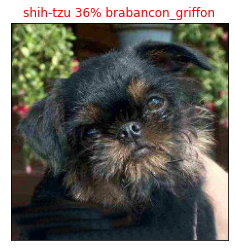

In [0]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=67)

Batch Visualizations:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
*Find the prediction using get_pred_label() ✅
*Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

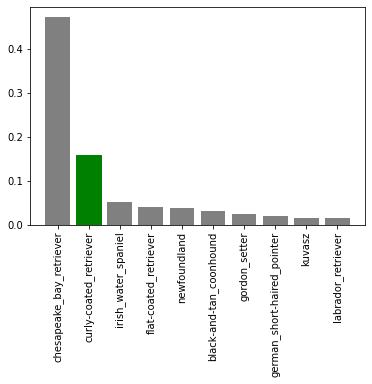

In [0]:

plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=76)

In [0]:
predictions[0].argsort()[-10:][::-1]

array([ 70,  59,  17,   6,  79,  26, 109, 103,  77,  35])

With the help of the visualization function, let's check predictions. 

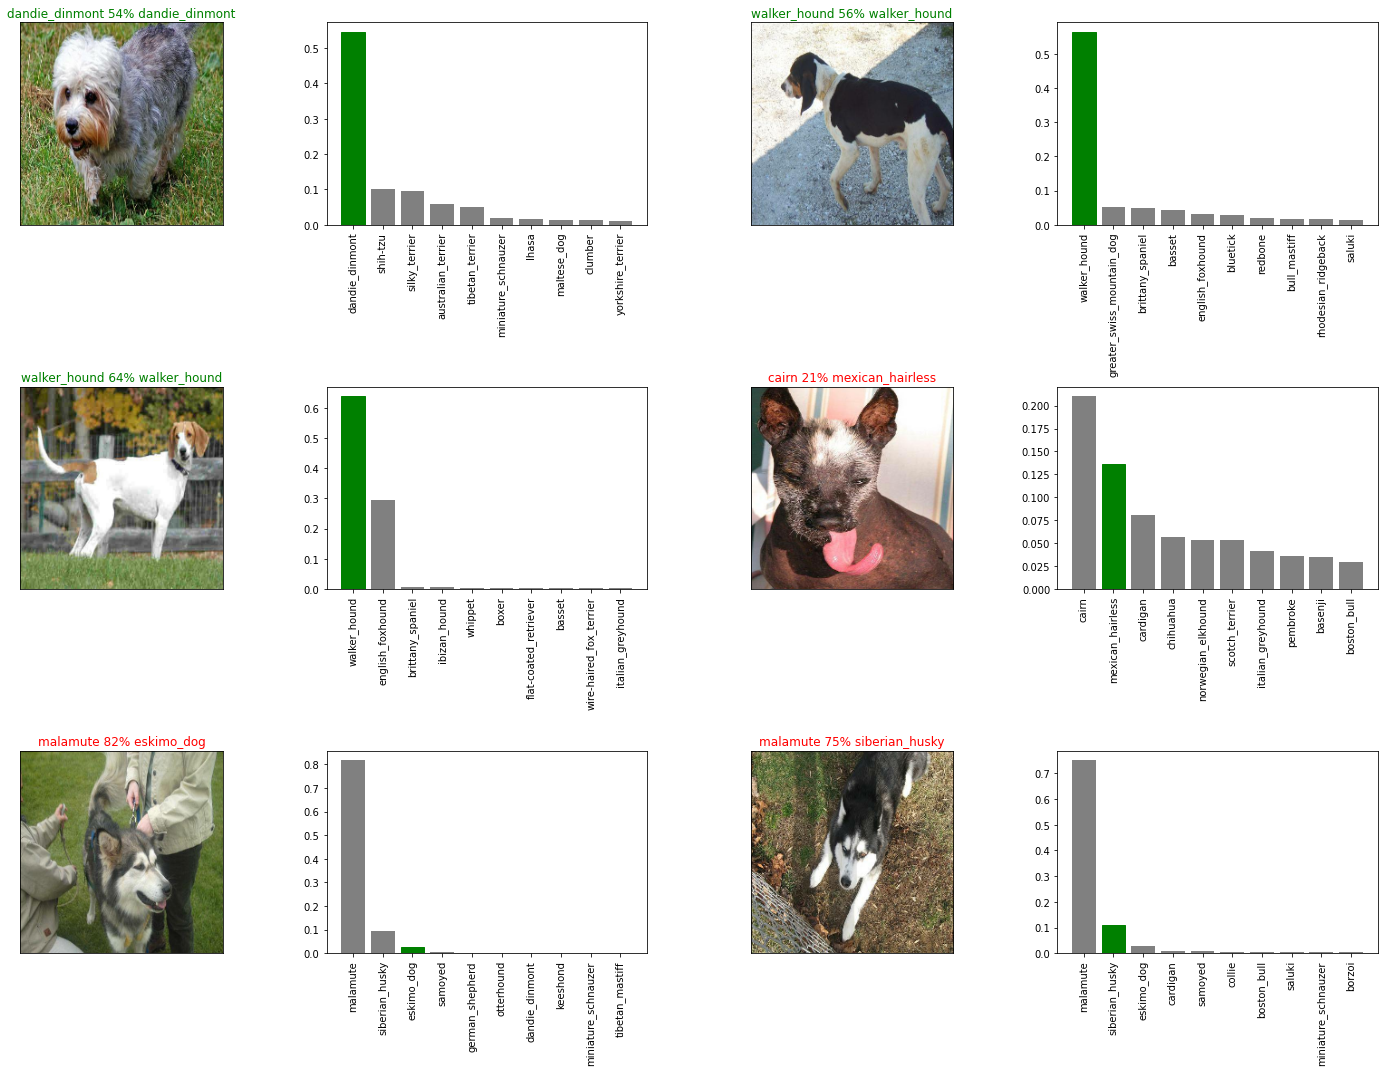

In [0]:
# Let's check out a few predictions and their different values
i_multiplier = 30
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:

# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Checking functions for load/save model:

In [0]:
# Save model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Dog Vision/models/20200412-00331586651613-1000-images-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog Vision/models/20200412-00331586651613-1000-images-mobilenetv2-Adam.h5'

In [0]:
# Load a trained model
loaded_1000_image_model = load_model('/content/drive/My Drive/Dog Vision/models/20200412-00331586651613-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200412-00331586651613-1000-images-mobilenetv2-Adam.h5


In [0]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 113ms/step - loss: 1.2885 - accuracy: 0.6550


[1.2884624004364014, 0.6549999713897705]

In [0]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 116ms/step - loss: 1.2885 - accuracy: 0.6550


[1.2884624004364014, 0.6549999713897705]

## Training on entire dataset

In [0]:
len(X), len(y)

(10222, 10222)

In [0]:
# Create a data batch with full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [0]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)


Note: Running the cell below takes 30 minutes for first epoch. GPU is loading all images into memory.

In [0]:

# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4774s 15s/step - loss: 1.3359 - accuracy: 0.6727
Epoch 2/100
320/320 [==============================] - 46s 145ms/step - loss: 0.4009 - accuracy: 0.8836
Epoch 3/100
320/320 [==============================] - 46s 145ms/step - loss: 0.2385 - accuracy: 0.9321
Epoch 4/100
320/320 [==============================] - 47s 146ms/step - loss: 0.1539 - accuracy: 0.9641
Epoch 5/100
320/320 [==============================] - 46s 145ms/step - loss: 0.1085 - accuracy: 0.9786
Epoch 6/100
320/320 [==============================] - 46s 144ms/step - loss: 0.0765 - accuracy: 0.9874
Epoch 7/100
320/320 [==============================] - 45s 142ms/step - loss: 0.0571 - accuracy: 0.9932
Epoch 8/100
320/320 [==============================] - 46s 143ms/step - loss: 0.0459 - accuracy: 0.9945
Epoch 9/100
320/320 [==============================] - 45s 141ms/step - loss: 0.0363 - accuracy: 0.9972
Epoch 10/100
320/320 [==============================] - 45s 142m

In [0]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Dog Vision/models/20200412-02261586658401-full-image-set-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog Vision/models/20200412-02261586658401-full-image-set-mobilenetv2-Adam.h5'

In [0]:
# Load in the full model
loaded_full_model = load_model("/content/drive/My Drive/Dog Vision/models/20200412-02261586658401-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200412-02261586658401-full-image-set-mobilenetv2-Adam.h5


## Make Predictions on Test Dataset
Use create_data_batches() to convert list of filenames to Tensor batches. 

Make predictions on the test data:

* Get the test image filenames. ✅
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels). ✅
*Make a predictions array by passing the test batches to the predict() method called on our model.

In [0]:
# Load test image filenames
test_path = "/content/drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog Vision/test/f5174e3ab52edb2e414e135259047c48.jpg',
 '/content/drive/My Drive/Dog Vision/test/f32ce9df6028804688984658e2b5164c.jpg',
 '/content/drive/My Drive/Dog Vision/test/f446eac396b0e74af84fab5069d28c68.jpg',
 '/content/drive/My Drive/Dog Vision/test/f5a6e430c2c363335d22ae0593d7533a.jpg',
 '/content/drive/My Drive/Dog Vision/test/eb0f81618a71ccf82982d70879464d89.jpg',
 '/content/drive/My Drive/Dog Vision/test/eb2f2ad0f785a7c85f8c62969be71e2a.jpg',
 '/content/drive/My Drive/Dog Vision/test/ec81d166f296c1809d8be99cdabb5904.jpg',
 '/content/drive/My Drive/Dog Vision/test/f1f42942df460f38181e12ebce695b5e.jpg',
 '/content/drive/My Drive/Dog Vision/test/eab189c5274b79b36dd566fea4e9847e.jpg',
 '/content/drive/My Drive/Dog Vision/test/ecab96d4268569065f73b4bb5ddffa59.jpg']

In [0]:
len(test_filenames)

10357

In [0]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [0]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>


Note: Calling predict() on full model and passing test data batch will take a long time to run (about a ~1hr)

In [0]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 5653s 17s/step


In [0]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("/content/drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [0]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("/content/drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [0]:
test_predictions[:10]

array([[5.30311854e-06, 9.16681592e-11, 3.84128146e-12, ...,
        3.46875371e-12, 1.31050795e-11, 4.72047965e-12],
       [1.26311609e-11, 2.79619487e-11, 9.99944806e-01, ...,
        1.64973363e-12, 4.75008444e-12, 1.17301134e-12],
       [6.71600553e-09, 1.60720544e-13, 4.99419906e-12, ...,
        3.04790831e-07, 8.52745359e-07, 1.18152388e-06],
       ...,
       [1.87594190e-10, 1.05234217e-10, 2.81061174e-10, ...,
        8.03682468e-11, 3.90097028e-07, 1.40452201e-07],
       [1.00216679e-09, 1.71762871e-09, 1.49441237e-09, ...,
        2.21227654e-11, 1.04018193e-06, 2.41859311e-07],
       [9.90980298e-10, 3.25581576e-11, 2.34497561e-13, ...,
        1.24943757e-13, 2.05309224e-11, 5.18386197e-14]])

In [0]:
test_predictions.shape

(10357, 120)

Kaggle test dataset format:  
> prediction outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [0]:
["id"] + list(unique_breeds)

['id',
 'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenen

In [0]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [0]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f5174e3ab52edb2e414e135259047c48  ...       4.72048e-12
1  f32ce9df6028804688984658e2b5164c  ...       1.17301e-12
2  f446eac396b0e74af84fab5069d28c68  ...       1.18152e-06
3  f5a6e430c2c363335d22ae0593d7533a  ...       5.33484e-13
4  eb0f81618a71ccf82982d70879464d89  ...       8.60239e-08

[5 rows x 121 columns]

In [0]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("/content/drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images (RIP Scoobie)
To make predictions on custom images:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [0]:
# Get custom image filepaths
custom_path = "/content/drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [0]:
custom_image_paths

['/content/drive/My Drive/Dog Vision/my-dog-photos/download.jpg',
 '/content/drive/My Drive/Dog Vision/my-dog-photos/Huskie.jpg',
 '/content/drive/My Drive/Dog Vision/my-dog-photos/scoobie.jpg',
 '/content/drive/My Drive/Dog Vision/my-dog-photos/fox-terrier-long.jpg',
 '/content/drive/My Drive/Dog Vision/my-dog-photos/1._DSC_0346_(10096362833).jpg']

In [0]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [0]:
custom_preds.shape

(5, 120)

In [0]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['french_bulldog',
 'siberian_husky',
 'beagle',
 'wire-haired_fox_terrier',
 'german_shepherd']

In [0]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

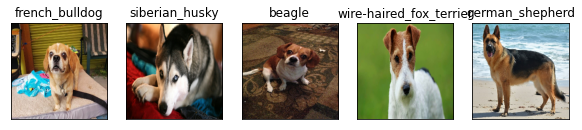

In [0]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.tight_layout
  plt.imshow(image)

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/My Drive/Dog Vision/')